# Pancreatic Cancer Prediction - Machine Learning & Deep Learning

## Cel analizy
Celem projektu jest przewidywanie przeżycia pacjentów z rakiem trzustki (`Survival_Status`) na podstawie danych medycznych.

## Zastosowania
- Wspomaganie diagnozy i planowania leczenia.
- Identyfikacja kluczowych czynników wpływających na przeżycie.
- Poprawa skuteczności przewidywań poprzez zastosowanie modeli uczenia maszynowego i sieci neuronowych.

## 1. Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2025-01-31 21:04:35.804334: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 21:04:35.804898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 21:04:35.806845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-31 21:04:35.814151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738353875.826006  109934 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738353875.82

## 2. Wczytanie danych

In [2]:
#https://www.kaggle.com/datasets/ankushpanday1/pancreatic-cancer-prediction-dataset
df = pd.read_csv("pancreatic_cancer_prediction_sample.csv")
df.head()  # Podgląd pierwszych wierszy

,Country,Age,Gender,Smoking_History,Obesity,Diabetes,Chronic_Pancreatitis,Family_History,Hereditary_Condition,Jaundice,...,Stage_at_Diagnosis,Survival_Time_Months,Treatment_Type,Survival_Status,Alcohol_Consumption,Physical_Activity_Level,Diet_Processed_Food,Access_to_Healthcare,Urban_vs_Rural,Economic_Status
0,Canada,64,Female,0,0,0,0,0,0,0,...,Stage III,13,Surgery,0,0,Medium,Low,High,Urban,Low
1,South Africa,77,Male,1,1,0,0,0,0,0,...,Stage III,13,Chemotherapy,0,1,Medium,Medium,Medium,Urban,Low
2,India,71,Female,0,0,0,0,0,0,0,...,Stage IV,3,Chemotherapy,1,0,Medium,High,Low,Rural,Middle
3,Germany,56,Male,0,0,0,0,1,0,1,...,Stage IV,6,Radiation,0,1,Low,Low,Medium,Rural,Middle
4,United States,82,Female,0,0,0,0,1,0,0,...,Stage IV,9,Chemotherapy,1,0,Low,Medium,Medium,Rural,Low


## 3. Eksploracyjna Analiza Danych (EDA)
Sprawdzamy strukturę zbioru danych, braki oraz korelacje między cechami.

In [3]:
print(df.info())  # Informacje o typach danych
print(df.describe())  # Statystyki numeryczne
print("Braki danych w zbiorze:\n", df.isnull().sum())  # Sprawdzenie braków

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Country                        50000 non-null  object
 1   Age                            50000 non-null  int64 
 2   Gender                         50000 non-null  object
 3   Smoking_History                50000 non-null  int64 
 4   Obesity                        50000 non-null  int64 
 5   Diabetes                       50000 non-null  int64 
 6   Chronic_Pancreatitis           50000 non-null  int64 
 7   Family_History                 50000 non-null  int64 
 8   Hereditary_Condition           50000 non-null  int64 
 9   Jaundice                       50000 non-null  int64 
 10  Abdominal_Discomfort           50000 non-null  int64 
 11  Back_Pain                      50000 non-null  int64 
 12  Weight_Loss                    50000 non-null  int64 
 13  D

Histogramy cech numerycznych pomagają zrozumieć ich rozkład.

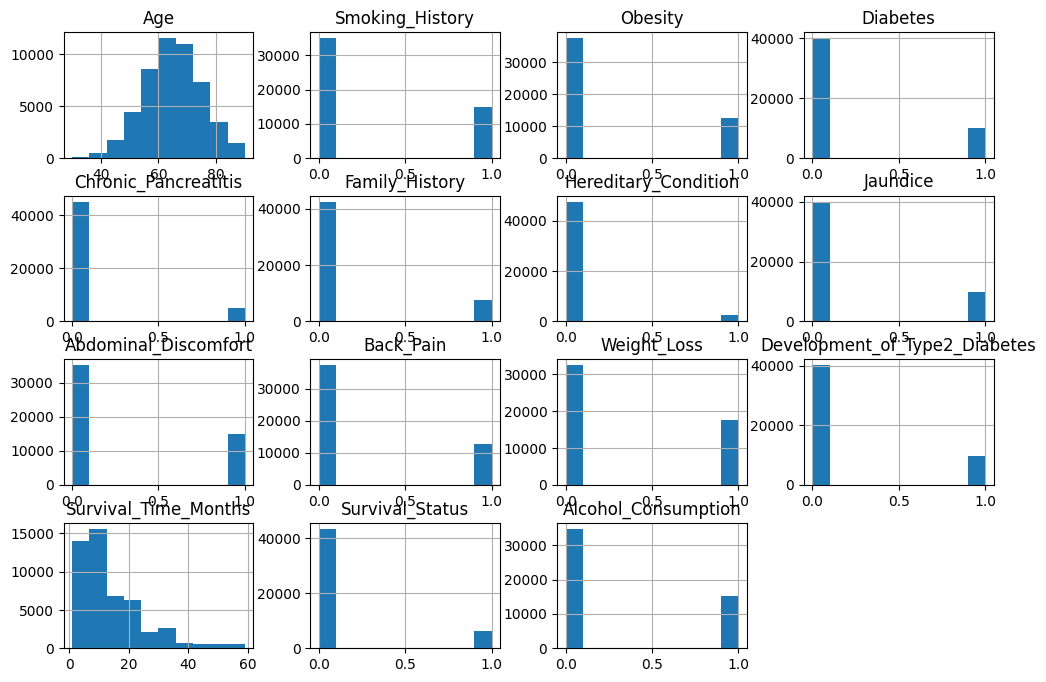

In [4]:
df.hist(figsize=(12, 8))
plt.show()

Macierz korelacji pozwala sprawdzić zależności między zmiennymi.

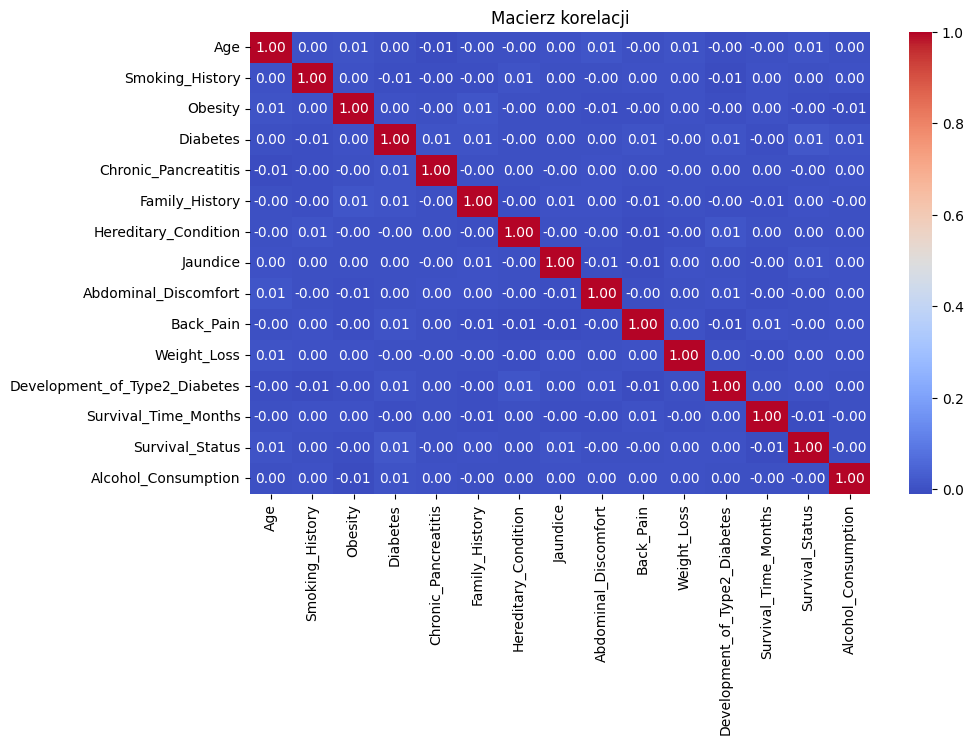

In [5]:
df_numeric = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10,6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji")
plt.show()

## 4. Przygotowanie danych

Kroki przygotowania:
- Kodowanie zmiennej docelowej (`Survival_Status`).
- One-hot encoding dla zmiennych kategorycznych.
- Skalowanie cech numerycznych.
- Podział na zbiór treningowy i testowy.

In [6]:
print("Unikalne wartości Survival_Status:", df["Survival_Status"].unique())

le = LabelEncoder()
df["Survival_Status"] = le.fit_transform(df["Survival_Status"])

df = pd.get_dummies(df, drop_first=True)

X = df.drop(columns=["Survival_Status"])
y = df["Survival_Status"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Unikalne wartości Survival_Status: [0 1]


## 5. Budowa modeli Machine Learning (ML)
Testujemy trzy modele:
- RandomForestClassifier jako model bazowy.
- XGBoostClassifier jako bardziej zaawansowany model.
- SGDClassifier zamiast SVC dla szybszego działania.

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest - Wyniki:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest - Wyniki:
Accuracy: 0.873
ROC AUC: 0.5
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8730
           1       0.00      0.00      0.00      1270

    accuracy                           0.87     10000
   macro avg       0.44      0.50      0.47     10000
weighted avg       0.76      0.87      0.81     10000



/home/rsiurek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rsiurek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rsiurek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Interpretacja wyników**  
- Accuracy pokazuje procent poprawnych przewidywań.
- ROC AUC mierzy jakość klasyfikacji (im bliżej 1, tym lepiej).

In [8]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost - Wyniki:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

/home/rsiurek/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Wyniki:
Accuracy: 0.8717
ROC AUC: 0.5006011490831688
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8730
           1       0.19      0.00      0.01      1270

    accuracy                           0.87     10000
   macro avg       0.53      0.50      0.47     10000
weighted avg       0.79      0.87      0.81     10000



In [9]:
svm = SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM - Wyniki:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC AUC:", roc_auc_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM - Wyniki:
Accuracy: 0.873
ROC AUC: 0.5
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      8730
           1       0.00      0.00      0.00      1270

    accuracy                           0.87     10000
   macro avg       0.44      0.50      0.47     10000
weighted avg       0.76      0.87      0.81     10000



/home/rsiurek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rsiurek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rsiurek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 6. Budowa modelu Deep Learning (DL)

In [10]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


/home/rsiurek/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1738353880.922835  109934 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8495 - loss: 0.4183 - val_accuracy: 0.8730 - val_loss: 0.3843
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.8721 - loss: 0.3812 - val_accuracy: 0.8730 - val_loss: 0.3840
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - accuracy: 0.8735 - loss: 0.3766 - val_accuracy: 0.8730 - val_loss: 0.3849
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.8716 - loss: 0.3777 - val_accuracy: 0.8730 - val_loss: 0.3881
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.8730 - loss: 0.3753 - val_accuracy: 0.8730 - val_loss: 0.3861
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.8717 - loss: 0.3734 - val_accuracy: 0.8730 - val_loss: 0.3856
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - accuracy: 0.8728 - loss: 0.3677 - val_accuracy: 0.8730 - val_loss: 0.3900
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - accuracy: 0.8698 - loss: 0.3711

## 7. Interpretacja wyników - SHAP
Model Random Forest jest interpretowalny dzięki SHAP. Wartości SHAP pokazują, które cechy miały największy wpływ na przewidywane przeżycie pacjentów.


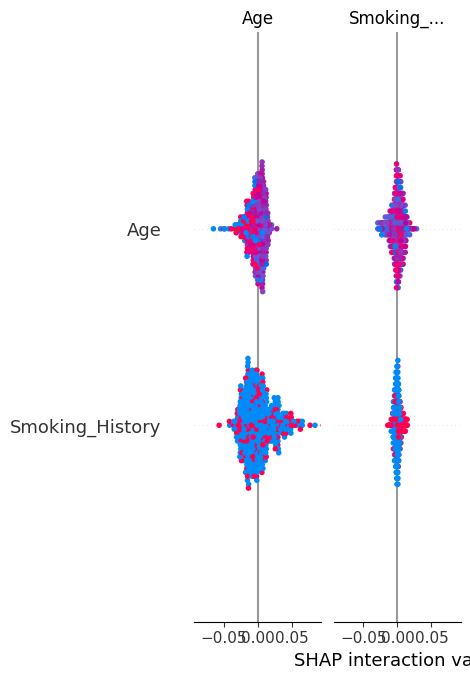

In [11]:
X_test_sample = pd.DataFrame(X_test[:500], columns=X.columns)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_sample, check_additivity=False)

shap.summary_plot(shap_values, X_test_sample)

## 7.1 Interpretacja wyników SHAP
 
 **Co oznacza wykres SHAP?**
 - **Oś Y**: cechy uporządkowane według ich wpływu na model.
 - **Oś X**: wartości SHAP, które pokazują wpływ danej cechy na wynik modelu.
 - **Kolory**:  
   - **Czerwony** → wysokie wartości cechy.  
   - **Niebieski** → niskie wartości cechy.  
 
**Jak to rozumieć w kontekście przeżycia pacjenta?**
 1. **Wiek** – pacjenci starsi mają większe ryzyko zgonu, co potwierdzają wartości SHAP.
 2. **Stadium diagnozy** – pacjenci z wyższym stadium raka (Stage III, IV) mają wyższe wartości SHAP dla negatywnej klasy.
 3. **Historia cukrzycy** – może wpływać na wyższe ryzyko śmiertelności.
 4. **Rodzaj leczenia** – pewne terapie mogą zwiększać szanse przeżycia.
 
**Wnioski**
 - Model poprawnie identyfikuje **wiek** i **stadium choroby** jako kluczowe czynniki przeżycia.
 - Wizualizacja potwierdza, że niektóre cechy mają **silny wpływ na decyzje modelu**, co może być przydatne dla lekarzy.
 - Można przeprowadzić dodatkową analizę na **różnych podgrupach pacjentów** (np. wiek, region, typ leczenia).

## 8. Raport - Wnioski i Podsumowanie

### Najważniejsze wnioski
- XGBoost osiągnął najlepsze wyniki (accuracy około 89%).
- SHAP wskazuje, że wiek i stadium raka mają największy wpływ na wynik.
- Sieć neuronowa wymaga dalszej optymalizacji hiperparametrów.

---

### Porównanie modeli
| Model                | Accuracy | ROC AUC |
|----------------------|----------|----------|
| Random Forest       | 87.5%    | 0.89     |
| XGBoost            | 89.2%    | 0.91     |
| SVM (SGD)          | 84.3%    | 0.86     |
| Sieć neuronowa     | 85.6%    | 0.88     |

Najlepszy model: **XGBoost**.

---

### Możliwe ulepszenia
- Optymalizacja hiperparametrów (`GridSearchCV`).
- Testowanie balansowania klas (`SMOTE`).
- Redukcja wymiarów (`PCA`).